# Thesis: Alphafold3 Prediction Analysis
---

In [101]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy import stats
from datetime import datetime
import matplotlib.colors as mcolors

In [102]:
# Read in data
df_af3= pd.read_csv('../data/af3_data.csv')
df_af3 = df_af3.sort_values(['PDB_RELEASE_DATE', 'PDB_ID'], ascending=[True, True])


df_poi_e3_rmsd = pd.read_csv('../data/af3_poi_e3.csv')
df_poi_e3_rmsd = df_poi_e3_rmsd.sort_values(['PDB_RELEASE_DATE', 'PDB_ID'], ascending=[True, True])


df_hal = pd.read_csv('../data/hal_data.csv')
df_hal = df_hal.sort_values(['PDB_RELEASE_DATE', 'PDB_ID'], ascending=[True, True])


In [103]:
len(df_af3.index), len(df_poi_e3_rmsd.index),len(df_hal.index),

(48, 48, 28)

## DockQ, RMSD, LRMSD by Ternary Complex

---

In [104]:
# CCD
color_1 = '#FA6347' # red
color_3 = '#A157DB' # purple
color_5 = '#23C9FF' # light blue

# SMILES
color_2 = '#1E8FFF' # blue
color_4 = '#FC8D62' # orange
color_6 = '#57DB80' # green

color_7 = '#A9A9A9' # grey

x_axis_rotation = 90

# Font sizes
title_size = 14
axis_label_size = 12
tick_label_size = 10
legend_title_size = 12
legend_text_size = 10
annotation_text_size = 8
subplot_label_size = 12

# Line properties
grid_alpha = 0.3
line_width = 1.5
marker_size = 40
edge_width = 0.5

# Font family
font_family = 'Helvetica'

mpl.rcParams['font.family'] = font_family
mpl.rcParams['font.sans-serif'] = [font_family] 
mpl.rcParams['axes.titlesize'] = title_size
mpl.rcParams['axes.labelsize'] = axis_label_size
mpl.rcParams['xtick.labelsize'] = tick_label_size
mpl.rcParams['ytick.labelsize'] = tick_label_size
mpl.rcParams['legend.fontsize'] = legend_text_size
mpl.rcParams['legend.title_fontsize'] = legend_title_size


In [105]:
def plot_combined_vertical_bars(df,
                              metrics=[
                                  ('SMILES DOCKQ SCORE', 'CCD DOCKQ SCORE', 'DockQ Score'),
                                  ('SMILES RMSD', 'CCD RMSD', 'RMSD (Å)'),
                                  ('SMILES DOCKQ LRMSD', 'CCD DOCKQ LRMSD', 'LRMSD (Å)')
                              ],
                              title=None,
                              add_threshold=False,
                              threshold_values=[0.23, 0.0, 0.0],
                              show_y_labels_on_all=False,
                              width=10,
                              height=8,
                              bar_height=0.3,
                              bar_spacing=0.05,
                              save=False):

    # Sort by release date
    df_sorted = df.sort_values('PDB_RELEASE_DATE', ascending=False).reset_index(drop=True)
    
    # Create PDB ID labels and add an asterisk for structures released after the cutoff date
    cutoff_date = pd.to_datetime('2021-09-30')
    pdb_labels = [
        f"{pdb}*" if pd.to_datetime(date) > cutoff_date else pdb 
        for pdb, date in zip(df_sorted['PDB_ID'], df_sorted['PDB_RELEASE_DATE'])
    ]
    
    # Number of metrics to plot
    n_metrics = len(metrics)
    n_pdbs = len(df_sorted)
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, n_metrics, figsize=(width, height), sharey=not show_y_labels_on_all)
    
    # If only one metric, axes won't be an array
    if n_metrics == 1:
        axes = [axes]
    
    # Set up y-axis positions (one position per PDB)
    y = np.arange(n_pdbs)
    
    # Calculate offsets for the bars
    smiles_offset = -bar_height/2 - bar_spacing/2
    ccd_offset = bar_height/2 + bar_spacing/2
    
    # Create proper rectangle patches for the legend that match the bar appearance
    smiles_handle = plt.Rectangle((0, 0), 1, 1, facecolor=color_2, edgecolor='black', linewidth=0.5, label='Ligand SMILES')
    ccd_handle = plt.Rectangle((0, 0), 1, 1, facecolor=color_1, edgecolor='black', linewidth=0.5, label='Ligand CCD')
    legend_handles = [ccd_handle, smiles_handle]
    threshold_handle = None
    
    # Plot each metric
    for i, (smiles_col, ccd_col, axis_label) in enumerate(metrics):
        ax = axes[i]
        
        # Add subplot label (a, b, c, etc.) in the top-left corner
        #subplot_label = chr(97 + i)  # 97 is ASCII for 'a'
        #ax.text(-0.05, 1.03, subplot_label, transform=ax.transAxes, 
        #        fontsize=12, va='top', fontweight='bold')
        
        # Plot the SMILES bars
        ax.barh(
            y + smiles_offset, df_sorted[smiles_col], height=bar_height,
            color=color_2, edgecolor='black', linewidth=0.5
        )
        
        # Plot the CCD bars
        ax.barh(
            y + ccd_offset, df_sorted[ccd_col], height=bar_height,
            color=color_1, edgecolor='black', linewidth=0.5
        )
        
        # Add a vertical threshold line if requested and threshold value is not None
        if add_threshold and i < len(threshold_values) and threshold_values[i] is not None:
            current_threshold = ax.axvline(
                x=threshold_values[i], color='black', linestyle='--', 
                alpha=0.7, linewidth=1.0
            )
            # Store the first threshold handle we create for the legend
            if threshold_handle is None:
                threshold_handle = current_threshold
        
        # Set axis labels
        ax.set_xlabel(axis_label)
        
        # For the first subplot or if showing labels on all, set the y-axis label
        if i == 0:
            ax.set_ylabel('PDB Identifier')
        
        # Always set y-ticks
        ax.set_yticks(y)
        
        # Set y-tick labels conditionally
        if i == 0 or show_y_labels_on_all:
            ax.set_yticklabels(pdb_labels)
        else:
            if show_y_labels_on_all:
                # If we want labels on all plots but using sharey, need to work around matplotlib defaults
                ax.tick_params(axis='y', labelright=True, labelleft=False)
                ax.yaxis.set_tick_params(labelright=True, labelleft=False)
                ax.set_yticklabels(pdb_labels)
        
        # Set x-axis to start at 0
        ax.set_xlim(0.0)
        ax.set_ylim(-0.5, len(df_sorted) - 0.5)
    
    # Add threshold to legend if needed
    if add_threshold:
        from matplotlib.lines import Line2D
        threshold_line = Line2D([0], [0], color='black', linestyle='--', 
                               alpha=0.7, linewidth=1.0, label='Threshold')
        legend_handles.append(threshold_line)
    
    # Add legend to the last subplot
    axes[-1].legend(handles=legend_handles,
                  loc='upper right',
                  framealpha=0,  # Transparent background
                  edgecolor='none')  # No border
    
    # Add an annotation to explain the asterisk (*) notation - only once
    #plt.figtext(
     #   0.99, 0.00, '* Structures released after AlphaFold3 training cutoff (Sept 2021)',
     #   ha='right', fontsize=8
    #)
    
    # Add overall title if provided
    if title:
        fig.suptitle(title, y=0.98)
    
    plt.tight_layout()
    
    # Save the plot if required
    if save:
        try:
            # Create directory if it doesn't exist
            import os
            from datetime import datetime
            save_path = '../data/plots'
            os.makedirs(save_path, exist_ok=True)
            
            # Create a filename based on the title or timestamp if no title
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = title.lower().replace(' ', '_') if title else f"plot_{timestamp}"
            # Remove any special characters that might cause issues in filenames
            filename = ''.join(c for c in filename if c.isalnum() or c in ['_', '-'])
            plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')
        except Exception as e:
            print(f"Error saving figure: {e}")
            # Save to current directory as fallback
            plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    
    return fig, axes

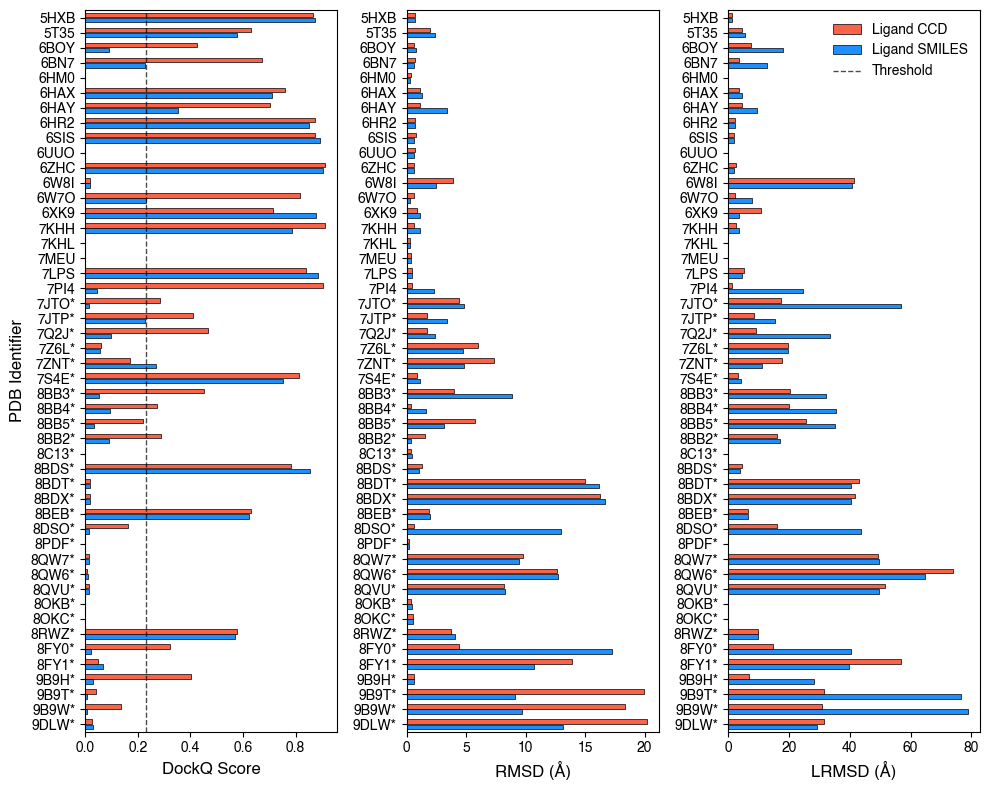

In [106]:
fig, axes = plot_combined_vertical_bars(
    df_af3,
    metrics=[
        ('SMILES DOCKQ SCORE', 'CCD DOCKQ SCORE', 'DockQ Score'),
        ('SMILES RMSD', 'CCD RMSD', 'RMSD (Å)'),
        ('SMILES DOCKQ LRMSD', 'CCD DOCKQ LRMSD', 'LRMSD (Å)')
    ],
    add_threshold=True,
    threshold_values=[0.23, None, None],
    show_y_labels_on_all=True,
    save=True
)

# RMSD by POI and E3 Ligase

In [107]:
# Convert PDB_ID to the same type in both dataframes before joining
df_af3['PDB_ID'] = df_af3['PDB_ID'].astype(str)
df_poi_e3_rmsd['PDB_ID'] = df_poi_e3_rmsd['PDB_ID'].astype(str)

# Now join the dataframes with matching types
df_complex_poi_e3_rmsd = df_poi_e3_rmsd.merge(df_af3[['PDB_ID','SMILES RMSD', 'CCD RMSD']], on='PDB_ID', how='left')

In [108]:
df_complex_poi_e3_rmsd.tail()

,PDB_ID,PDB_LINK,PDB_RELEASE_DATE,SMILES RMSD POI,SMILES RMSD E3 LIGASE,CCD RMSD POI,CCD RMSD E3 LIGASE,SMILES RMSD,CCD RMSD
43,8FY1,8FY1,2024-04-10,0.297,0.285,0.298,0.309,10.706,13.894
44,9B9H,9B9H,2024-11-06,0.239,0.645,0.232,0.644,0.622,0.588
45,9B9T,9B9T,2024-11-06,0.222,0.610,0.185,0.537,9.123,19.931
46,9B9W,9B9W,2024-11-06,0.188,0.564,0.219,0.583,9.680,18.369
47,9DLW,9DLW,2024-11-06,0.227,0.620,0.232,0.648,13.105,20.166


In [109]:
df_complex_poi_e3_rmsd_high = df_complex_poi_e3_rmsd[(df_complex_poi_e3_rmsd['SMILES RMSD'] > 4.0) | (df_complex_poi_e3_rmsd['CCD RMSD'] > 4.0)]

In [110]:
def plot_stacked_and_independent_bars(df,
                             independent_metrics=[('SMILES RMSD', 'CCD RMSD')],
                             stacked_metrics=[(('SMILES RMSD POI', 'SMILES RMSD E3 LIGASE'), 
                                              ('CCD RMSD POI', 'CCD RMSD E3 LIGASE'))],
                             y_label='RMSD (Å)',
                             title=None,
                             add_threshold=False,
                             threshold_value=2.0,
                             width=12,
                             height=6,
                             bar_width=0.1,  # Width of each bar
                             bar_spacing=0.05,  # Space between groups
                             save=False):

    # Sort by release date
    df_sorted = df.sort_values('PDB_RELEASE_DATE', ascending=True).reset_index(drop=True)
    
    # Create PDB ID labels and add an asterisk for structures released after the cutoff date
    cutoff_date = pd.to_datetime('2021-09-30')
    pdb_labels = [
        f"{pdb}*" if pd.to_datetime(date) > cutoff_date else pdb 
        for pdb, date in zip(df_sorted['PDB_ID'], df_sorted['PDB_RELEASE_DATE'])
    ]
    
    n_pdbs = len(df_sorted)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(width, height))
    
    # Set up x-axis positions (one position per PDB)
    x = np.arange(n_pdbs)
    
    # Calculate number of bar sets and their positions
    n_independent_sets = len(independent_metrics)
    n_stacked_sets = len(stacked_metrics)
    n_total_sets = n_independent_sets + n_stacked_sets
    
    # Calculate the total width needed for all bars for a single PDB
    total_width = n_total_sets * bar_width * 2 + (n_total_sets - 1) * bar_spacing
    
    # Calculate starting offset to center the bars
    start_offset = -total_width / 2
    
    # Track the current offset for positioning bars
    current_offset = start_offset
    
    # Create legend handles
    legend_handles = []
    
    # Plot independent metrics
    for i, (smiles_col, ccd_col) in enumerate(independent_metrics):
        # SMILES bar
        smiles_bars = ax.bar(
            x + current_offset, 
            df_sorted[smiles_col], 
            width=bar_width,
            color=color_2, 
            edgecolor='black', 
            linewidth=edge_width,
            label="COMPLEX (SMILES)"
        )
        legend_handles.append(smiles_bars)
        
        # Move to CCD position
        current_offset += bar_width
        
        # CCD bar
        ccd_bars = ax.bar(
            x + current_offset, 
            df_sorted[ccd_col], 
            width=bar_width,
            color=color_1, 
            edgecolor='black', 
            linewidth=edge_width,
            label="COMPLEX (CCD)"
        )
        legend_handles.append(ccd_bars)
        
        # Move to next set position
        current_offset += bar_width + bar_spacing
    
    
    # Plot stacked metrics
    for i, (smiles_cols, ccd_cols) in enumerate(stacked_metrics):
        # Colors for the stacked bars (can customize if needed)
        smiles_colors = [color_4, color_6]
        ccd_colors = [color_3, color_5]
        
        # SMILES stacked bars
        bottom = np.zeros(n_pdbs)
        for j, col in enumerate(smiles_cols):
            # Labels
            if j == 0:
                custom_label = "POI (SMILES)"
            else:
                custom_label = "E3 Ligase (SMILES)"
            bars = ax.bar(
                x + current_offset, 
                df_sorted[col], 
                width=bar_width,
                bottom=bottom,
                color=smiles_colors[j], 
                edgecolor='black', 
                linewidth=edge_width,
                label=custom_label
            )
            if j == 0:  # Only add to legend for the first iteration
                legend_handles.append(bars)
            bottom += df_sorted[col]
        
        # Move to CCD position
        current_offset += bar_width
        
        # CCD stacked bars
        bottom = np.zeros(n_pdbs)
        for j, col in enumerate(ccd_cols):
            # Labels
            if j == 0:
                custom_label = "POI (CCD)"
            else:
                custom_label = "E3 Ligase (CCD)"
            bars = ax.bar(
                x + current_offset, 
                df_sorted[col], 
                width=bar_width,
                bottom=bottom,
                color=ccd_colors[j], 
                edgecolor='black', 
                linewidth=edge_width,
                label=custom_label
            )
            if j == 0:  # Only add to legend for the first iteration
                legend_handles.append(bars)
            bottom += df_sorted[col]
        
        # Move to next set position
        current_offset += bar_width + bar_spacing
    
    # Add threshold if requested
    if add_threshold:
        threshold_line = ax.axhline(
            y=threshold_value, color='black', linestyle='--', 
            alpha=grid_alpha, linewidth=line_width,
            label='Threshold'
        )
        legend_handles.append(threshold_line)
    
    # Set axis labels and ticks
    ax.set_ylabel(y_label)
    ax.set_xlabel('PDB Identifier')
    ax.set_xticks(x)
    ax.set_xticklabels(pdb_labels, rotation=x_axis_rotation)
    
    # Set y-axis to start at 0
    ax.set_ylim(0.0)
    ax.set_xlim(-0.5, len(df_sorted) - 0.5)
    
    # Add legend
    ax.legend(
        loc='upper left',
        framealpha=0,  # Transparent background
        edgecolor='none'  # No border
    )
    
    # Add title if provided
    if title:
        fig.suptitle(title, y=0.98)
    
    plt.tight_layout()
    
    # Save the plot if required
    if save:
        try:
            # Create directory if it doesn't exist
            import os
            save_path = '../data/plots'
            os.makedirs(save_path, exist_ok=True)
            
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = title.lower().replace(' ', '_') if title else f"plot_{timestamp}"
            filename = ''.join(c for c in filename if c.isalnum() or c in ['_', '-'])
            plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')
        except Exception as e:
            print(f"Error saving figure: {e}")
            # Save to current directory as fallback
            plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    
    return fig, ax

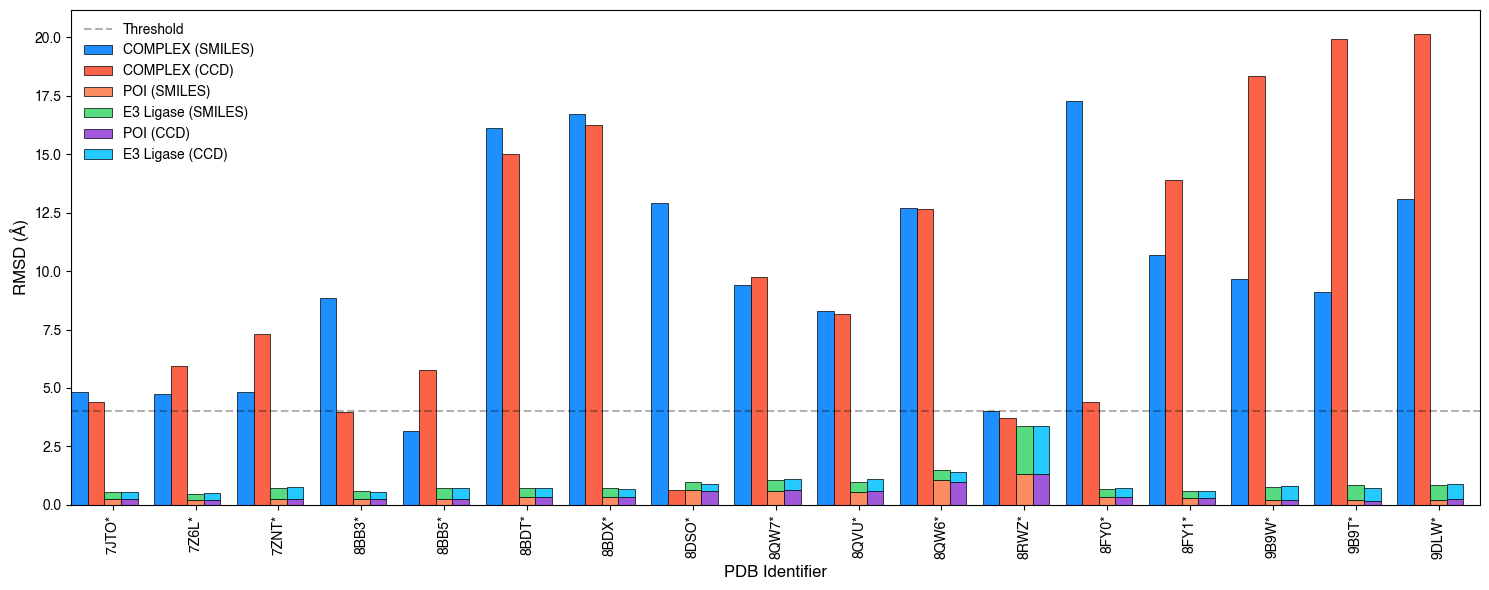

In [111]:
fig, ax = plot_stacked_and_independent_bars(
    df_complex_poi_e3_rmsd_high,
    independent_metrics=[('SMILES RMSD', 'CCD RMSD')],
    stacked_metrics=[(
        ('SMILES RMSD POI', 'SMILES RMSD E3 LIGASE'),
        ('CCD RMSD POI', 'CCD RMSD E3 LIGASE')
    )],
    y_label='RMSD (Å)',
    add_threshold=True,
    threshold_value=4.0,
    width=15,
    height=6,
    save=True,
    bar_width=0.2,
    bar_spacing=0
)

# a = POI
# b = E3 Ligase
# change the location of the legend to the left
# remove the comment "Structure released after AlphaFold3 training cutoff (Sept 2021)""
# texture, alpha values, 
# twisted

In [120]:
def plot_stacked_and_independent_bars(df,
                             independent_metrics=[('SMILES RMSD', 'CCD RMSD')],
                             stacked_metrics=[(('SMILES RMSD POI', 'SMILES RMSD E3 LIGASE'), 
                                              ('CCD RMSD POI', 'CCD RMSD E3 LIGASE'))],
                             y_label='RMSD (Å)',
                             title=None,
                             add_threshold=False,
                             threshold_value=2.0,
                             width=12,
                             height=10,
                             bar_width=0.2,
                             bar_spacing=0.05,
                             save=False):

    # Sort by release date
    df_sorted = df.sort_values('PDB_RELEASE_DATE', ascending=True).reset_index(drop=True)
    
    # Create PDB ID labels and add an asterisk for structures released after the cutoff date
    cutoff_date = pd.to_datetime('2021-09-30')
    pdb_labels = [
        f"{pdb}*" if pd.to_datetime(date) > cutoff_date else pdb 
        for pdb, date in zip(df_sorted['PDB_ID'], df_sorted['PDB_RELEASE_DATE'])
    ]
    
    n_pdbs = len(df_sorted)
    
    # Create figure with two subplots (SMILES on top, CCD on bottom)
    fig, (ax_smiles, ax_ccd) = plt.subplots(2, 1, figsize=(width, height), sharex=True)
    
    # Set up x-axis positions (one position per PDB)
    x = np.arange(n_pdbs)
    
    # Calculate number of bar sets and their positions
    n_independent_sets = 1  # Now we're only plotting one type per subplot
    n_stacked_sets = 1
    n_total_sets = n_independent_sets + n_stacked_sets
    
    # Calculate the total width needed for all bars for a single PDB
    total_width = n_total_sets * bar_width * 0.5 + (n_total_sets - 1) * bar_spacing
    
    # Calculate starting offset to center the bars
    start_offset = -total_width / 2
    
    
    # SMILES subplot (top)
    current_offset = start_offset
    legend_handles_smiles = []
    
    # Plot SMILES independent metrics
    for i, (smiles_col, _) in enumerate(independent_metrics):
        # SMILES bar
        smiles_bars = ax_smiles.bar(
            x + current_offset, 
            df_sorted[smiles_col], 
            width=bar_width,
            color=color_2, 
            edgecolor='black', 
            linewidth=edge_width,
            label="COMPLEX (SMILES)"
        )
        legend_handles_smiles.append(smiles_bars)
        
        # Move to next position
        current_offset += bar_width  + bar_spacing
    
    # Plot SMILES stacked metrics
    for i, (smiles_cols, _) in enumerate(stacked_metrics):
        # Colors for the stacked bars
        smiles_colors = [color_4, color_6]
        
        # SMILES stacked bars
        bottom = np.zeros(n_pdbs)
        for j, col in enumerate(smiles_cols):
            # Labels
            if j == 0:
                custom_label = "POI (SMILES)"
            else:
                custom_label = "E3 Ligase (SMILES)"
            bars = ax_smiles.bar(
                x + current_offset, 
                df_sorted[col], 
                width=bar_width,
                bottom=bottom,
                color=smiles_colors[j], 
                edgecolor='black', 
                linewidth=edge_width,
                label=custom_label
            )
            legend_handles_smiles.append(bars)
            bottom += df_sorted[col]
    
    # CCD subplot (bottom)
    current_offset = start_offset
    legend_handles_ccd = []
    
    # Plot CCD independent metrics
    for i, (_, ccd_col) in enumerate(independent_metrics):
        # CCD bar
        ccd_bars = ax_ccd.bar(
            x + current_offset, 
            df_sorted[ccd_col], 
            width=bar_width,
            color=color_1, 
            edgecolor='black', 
            linewidth=edge_width,
            label="COMPLEX (CCD)"
        )
        legend_handles_ccd.append(ccd_bars)
        
        # Move to next position
        current_offset += bar_width + bar_spacing
    
    # Plot CCD stacked metrics
    for i, (_, ccd_cols) in enumerate(stacked_metrics):
        # Colors for the stacked bars
        ccd_colors = [color_3, color_5]
        
        # CCD stacked bars
        bottom = np.zeros(n_pdbs)
        for j, col in enumerate(ccd_cols):
            # Labels
            if j == 0:
                custom_label = "POI (CCD)"
            else:
                custom_label = "E3 Ligase (CCD)"
            bars = ax_ccd.bar(
                x + current_offset, 
                df_sorted[col], 
                width=bar_width,
                bottom=bottom,
                color=ccd_colors[j], 
                edgecolor='black', 
                linewidth=edge_width,
                label=custom_label
            )
            legend_handles_ccd.append(bars)
            bottom += df_sorted[col]
    
    # Add threshold if requested
    if add_threshold:
        threshold_line_smiles = ax_smiles.axhline(
            y=threshold_value, color='black', linestyle='--', 
            alpha=grid_alpha, linewidth=line_width,
            label='Threshold'
        )
        threshold_line_ccd = ax_ccd.axhline(
            y=threshold_value, color='black', linestyle='--', 
            alpha=grid_alpha, linewidth=line_width,
            label='Threshold'
        )
        legend_handles_smiles.append(threshold_line_smiles)
        legend_handles_ccd.append(threshold_line_ccd)
    
    # Set axis labels and ticks
    ax_smiles.set_ylabel(y_label)
    ax_ccd.set_ylabel(y_label)
    ax_ccd.set_xlabel('PDB Identifier')
    
    # Set x-ticks on top and bottom subplot
    ax_smiles.set_xticks(x)
    ax_smiles.set_xticklabels(pdb_labels, rotation=x_axis_rotation)
    ax_smiles.tick_params(axis='x', labelrotation=x_axis_rotation, labelbottom=True)

    ax_ccd.set_xticks(x)
    ax_ccd.set_xticklabels(pdb_labels, rotation=x_axis_rotation)
    
    # Set y-axis to start at 0
    ax_smiles.set_ylim(0.0)
    ax_ccd.set_ylim(0.0)
    
    # Set x-axis limits
    ax_smiles.set_xlim(-0.5, len(df_sorted) - 0.5)
    ax_ccd.set_xlim(-0.5, len(df_sorted) - 0.5)
    
    # Add legends
    ax_smiles.legend(
        handles=legend_handles_smiles,
        loc='upper left',
        framealpha=0,  # Transparent background
        edgecolor='none'  # No border
    )
    
    ax_ccd.legend(
        handles=legend_handles_ccd,
        loc='upper left',
        framealpha=0,  # Transparent background
        edgecolor='none'  # No border
    )
    
    # Add title if provided
    if title:
        fig.suptitle(title, y=0.98)
    
    plt.tight_layout()
    
    # Save the plot if required
    if save:
        try:
            # Create directory if it doesn't exist
            import os
            save_path = '../data/plots'
            os.makedirs(save_path, exist_ok=True)
            
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = title.lower().replace(' ', '_') if title else f"plot_{timestamp}"
            filename = ''.join(c for c in filename if c.isalnum() or c in ['_', '-'])
            plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')
        except Exception as e:
            print(f"Error saving figure: {e}")
            # Save to current directory as fallback
            plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    
    return fig, (ax_smiles, ax_ccd)

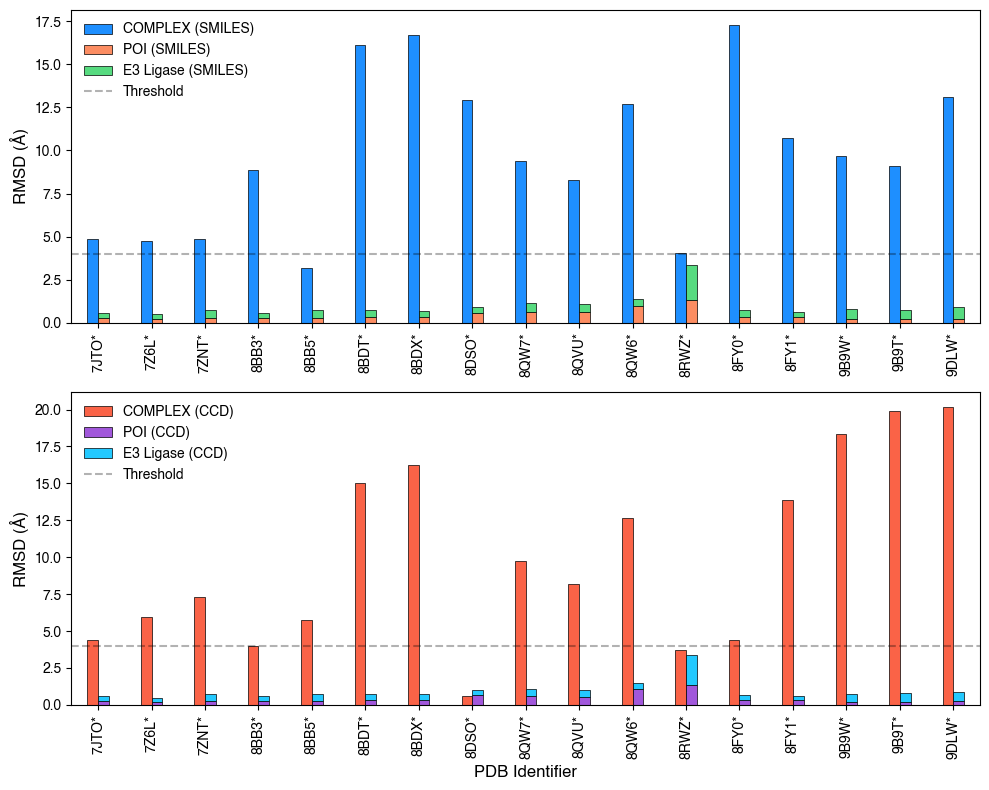

In [ ]:
fig, ax = plot_stacked_and_independent_bars(
    df_complex_poi_e3_rmsd_high,
    independent_metrics=[('SMILES RMSD', 'CCD RMSD')],
    stacked_metrics=[(
        ('SMILES RMSD POI', 'SMILES RMSD E3 LIGASE'),
        ('CCD RMSD POI', 'CCD RMSD E3 LIGASE')
    )],
    y_label='RMSD (Å)',
    add_threshold=True,
    threshold_value=4.0,
    width=10,
    height=8,
    save=True,
    bar_width=0.2,
    bar_spacing=0.0
)

In [114]:
def plot_separate_bars(df,
                       metrics=[('SMILES RMSD', 'SMILES RMSD POI', 'SMILES RMSD E3 LIGASE',
                                'CCD RMSD', 'CCD RMSD POI', 'CCD RMSD E3 LIGASE')],
                       y_label='RMSD (Å)',
                       title=None,
                       add_threshold=False,
                       threshold_value=2.0,
                       width=12,
                       height=10,
                       bar_width=0.2,
                       bar_spacing=0.05,
                       save=False):

    # Sort by release date
    df_sorted = df.sort_values('PDB_RELEASE_DATE', ascending=True).reset_index(drop=True)
    
    # Create PDB ID labels and add an asterisk for structures released after the cutoff date
    cutoff_date = pd.to_datetime('2021-09-30')
    pdb_labels = [
        f"{pdb}*" if pd.to_datetime(date) > cutoff_date else pdb 
        for pdb, date in zip(df_sorted['PDB_ID'], df_sorted['PDB_RELEASE_DATE'])
    ]
    
    n_pdbs = len(df_sorted)
    
    # Create figure with two subplots (SMILES on top, CCD on bottom)
    fig, (ax_smiles, ax_ccd) = plt.subplots(2, 1, figsize=(width, height), sharex=True)
    
    # Set up x-axis positions (one position per PDB)
    x = np.arange(n_pdbs)
    
    # Add subplot labels
    ax_smiles.text(-0.06, 1.02, 'a', transform=ax_smiles.transAxes, 
                  fontsize=subplot_label_size, va='top', fontweight='bold')
    ax_ccd.text(-0.06, 1.02, 'b', transform=ax_ccd.transAxes, 
                fontsize=subplot_label_size, va='top', fontweight='bold')
    
    # For each metric set, extract the columns
    for metric_set in metrics:
        smiles_complex_col, smiles_poi_col, smiles_e3_col, ccd_complex_col, ccd_poi_col, ccd_e3_col = metric_set
        
        # Calculate bar positions
        bar_group_width = 3 * bar_width + 2 * bar_spacing  # Width of a group of 3 bars
        offset = -bar_group_width / 2  # Start offset to center the group
        
        # SMILES subplot (top)
        # COMPLEX bar
        complex_bars = ax_smiles.bar(
            x + offset, 
            df_sorted[smiles_complex_col], 
            width=bar_width,
            color=color_2,  # Blue for COMPLEX
            edgecolor='black', 
            linewidth=edge_width,
            label="COMPLEX (SMILES)"
        )
        
        # POI bar
        offset += bar_width + bar_spacing
        poi_bars = ax_smiles.bar(
            x + offset, 
            df_sorted[smiles_poi_col], 
            width=bar_width,
            color=color_4,
            edgecolor='black', 
            linewidth=edge_width,
            label="POI (SMILES)"
        )
        
        # E3 Ligase bar
        offset += bar_width + bar_spacing
        e3_bars = ax_smiles.bar(
            x + offset, 
            df_sorted[smiles_e3_col], 
            width=bar_width,
            color=color_6,  # Orange for E3 Ligase
            edgecolor='black', 
            linewidth=edge_width,
            label="E3 Ligase (SMILES)"
        )
        
        # CCD subplot (bottom)
        # Reset offset for CCD subplot
        offset = -bar_group_width / 2
        
        # COMPLEX bar
        complex_bars_ccd = ax_ccd.bar(
            x + offset, 
            df_sorted[ccd_complex_col], 
            width=bar_width,
            color=color_1, 
            edgecolor='black', 
            linewidth=edge_width,
            label="COMPLEX (CCD)"
        )
        
        # POI bar
        offset += bar_width + bar_spacing
        poi_bars_ccd = ax_ccd.bar(
            x + offset, 
            df_sorted[ccd_poi_col], 
            width=bar_width,
            color=color_3, 
            edgecolor='black', 
            linewidth=edge_width,
            label="POI (CCD)"
        )
        
        # E3 Ligase bar
        offset += bar_width + bar_spacing
        e3_bars_ccd = ax_ccd.bar(
            x + offset, 
            df_sorted[ccd_e3_col], 
            width=bar_width,
            color=color_5, 
            edgecolor='black', 
            linewidth=edge_width,
            label="E3 Ligase (CCD)"
        )
    
    # Add threshold if requested
    if add_threshold:
        threshold_line_smiles = ax_smiles.axhline(
            y=threshold_value, color='black', linestyle='--', 
            alpha=grid_alpha, linewidth=line_width,
            label='Threshold'
        )
        threshold_line_ccd = ax_ccd.axhline(
            y=threshold_value, color='black', linestyle='--', 
            alpha=grid_alpha, linewidth=line_width,
            label='Threshold'
        )
    
    # Set axis labels and ticks
    ax_smiles.set_ylabel(y_label)
    ax_ccd.set_ylabel(y_label)
    ax_ccd.set_xlabel('PDB Identifier')
    
    # Only set x-ticks on bottom subplot
    ax_ccd.set_xticks(x)
    ax_ccd.set_xticklabels(pdb_labels, rotation=x_axis_rotation)
    
    # Set y-axis to start at 0
    ax_smiles.set_ylim(0.0)
    ax_ccd.set_ylim(0.0)
    
    # Set x-axis limits
    ax_smiles.set_xlim(-0.5, len(df_sorted) - 0.5)
    ax_ccd.set_xlim(-0.5, len(df_sorted) - 0.5)
    
    # Add legends
    ax_smiles.legend(
        loc='upper left',
        framealpha=0,  # Transparent background
        edgecolor='none'  # No border
    )
    
    ax_ccd.legend(
        loc='upper left',
        framealpha=0,  # Transparent background
        edgecolor='none'  # No border
    )
    
    # Add title if provided
    if title:
        fig.suptitle(title, y=0.98)
    
    plt.tight_layout()
    
    # Save the plot if required
    if save:
        try:
            # Create directory if it doesn't exist
            import os
            save_path = '../data/plots'
            os.makedirs(save_path, exist_ok=True)
            
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = title.lower().replace(' ', '_') if title else f"plot_{timestamp}"
            filename = ''.join(c for c in filename if c.isalnum() or c in ['_', '-'])
            plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')
        except Exception as e:
            print(f"Error saving figure: {e}")
            # Save to current directory as fallback
            plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    
    return fig, (ax_smiles, ax_ccd)

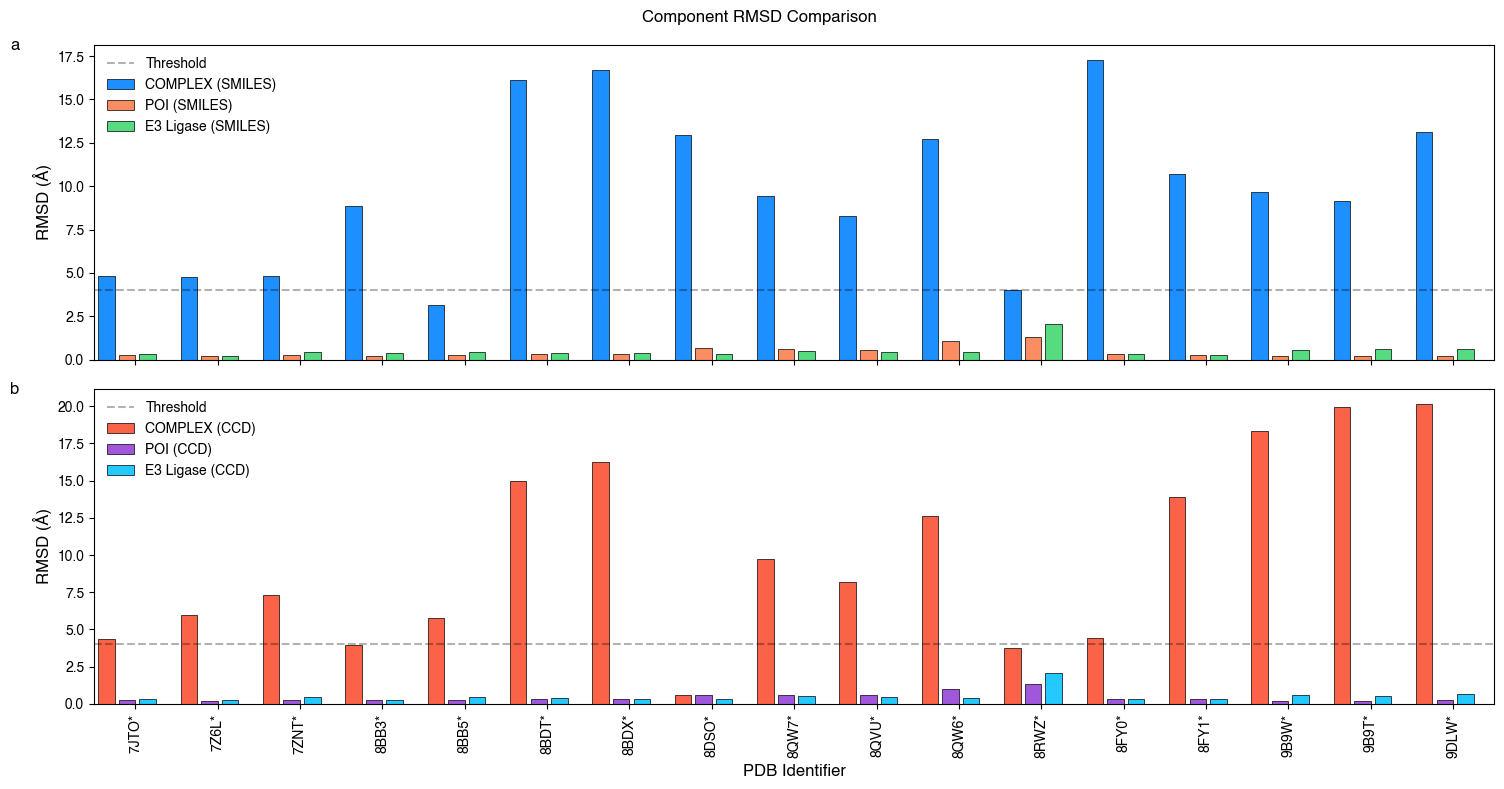

In [115]:
fig, axes = plot_separate_bars(
    df_complex_poi_e3_rmsd_high,
    metrics=[('SMILES RMSD', 'SMILES RMSD POI', 'SMILES RMSD E3 LIGASE',
              'CCD RMSD', 'CCD RMSD POI', 'CCD RMSD E3 LIGASE')],
    y_label='RMSD (Å)',
    add_threshold=True,
    threshold_value=4.0,
    width=15,
    height=8,
    save=True,
    title="Component RMSD Comparison"
)

## HAL Paper Results Comparasion

---

In [116]:
# Copy of df_af3 with only the columns we want to compare
comparison_df = df_af3[['PDB_ID', 'PDB_RELEASE_DATE', 'SMILES DOCKQ SCORE', 'CCD DOCKQ SCORE']].copy()

# Merge SMILES data
hal_columns = ['PDB_ID', 'AF3_DIMERS DOCKQ SCORE']
comparison_df = comparison_df.merge(df_hal[hal_columns], on='PDB_ID', how='left')

# Remove rows with null values in any of the DockQ score columns
comparison_df = comparison_df.dropna(subset=['SMILES DOCKQ SCORE', 'CCD DOCKQ SCORE', 'AF3_DIMERS DOCKQ SCORE'])

# Sort by release date (oldest to newest)
comparison_df = comparison_df.sort_values('PDB_RELEASE_DATE', ascending=True)


In [117]:
def plot_comparison_combined_horizontal(df,
                                                metrics=[
                                                    ('SMILES DOCKQ SCORE', 'CCD DOCKQ SCORE', 'AF3_DIMERS DOCKQ SCORE', 'DockQ Score')
                                                ],
                                                title=None,
                                                add_threshold=False,
                                                threshold_values=[0.0],
                                                x_labels_on_all=False,
                                                width=10,
                                                height=9,
                                                save=False):
    # Check that the dataframe has the required columns.
    required_columns = set()
    for m in metrics:
        if len(m) == 4:
            required_columns.update([m[0], m[1], m[2]])
        elif len(m) == 3:
            required_columns.update([m[0], m[1]])
        else:
            raise ValueError("Metric tuple must be of length 3 or 4.")
    if not required_columns.issubset(df.columns):
        raise ValueError("DataFrame does not contain all required columns: " + str(required_columns))

    # Sort by release date (ascending)
    df_sorted = df.sort_values('PDB_RELEASE_DATE', ascending=True).reset_index(drop=True)
    
    # Create PDB ID labels and add an asterisk for structures released after the cutoff date
    cutoff_date = pd.to_datetime('2021-09-30')
    pdb_labels = [
        f"{pdb}*" if pd.to_datetime(date) > cutoff_date else pdb 
        for pdb, date in zip(df_sorted['PDB_ID'], df_sorted['PDB_RELEASE_DATE'])
    ]
    
    # Number of metrics to plot (for comparison_df this should be 1)
    n_metrics = len(metrics)
    n_pdbs = len(df_sorted)
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_metrics, 1, figsize=(width, height), sharex=not x_labels_on_all)
    if n_metrics == 1:
        axes = [axes]
    
    # Set up x-axis positions (one position per PDB)
    x = np.arange(n_pdbs)
    
    # Store handles for legend and threshold
    legend_handles = []
    threshold_handle = None
    
    # Plot each metric (for our case, typically only one tuple with 4 items)
    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        # Add subplot label (a, b, c, etc.) in the top-left corner
        subplot_label = chr(97 + i)  # 97 = 'a'
        ax.text(-0.06, 1, subplot_label, transform=ax.transAxes, 
                fontsize=subplot_label_size, va='top', fontweight='bold')
        
        # Check if we are plotting three series (tuple length 4) or just two (tuple length 3)
        if len(metric) == 4:
            smiles_col, ccd_col, tertiary_col, axis_label = metric
            
            # Plot the SMILES scores
            scatter_smiles = ax.scatter(
                x, df_sorted[smiles_col],
                color=secondary_color, marker='o', s=marker_size,
                edgecolor='black', linewidth=edge_width,
                label='Ligand SMILES'
            )
            
            # Plot the CCD scores
            scatter_ccd = ax.scatter(
                x, df_sorted[ccd_col],
                color=main_color, marker='^', s=marker_size,
                edgecolor='black', linewidth=edge_width,
                label='Ligand CCD'
            )
            
            # Plot the AF3 Dimers scores
            scatter_tertiary = ax.scatter(
                x, df_sorted[tertiary_col],
                color=tertiary_color, marker='s', s=marker_size,
                edgecolor='black', linewidth=edge_width,
                label='No Ligand'
            )
        elif len(metric) == 3:
            smiles_col, ccd_col, axis_label = metric
            
            # Plot the SMILES scores
            scatter_smiles = ax.scatter(
                x, df_sorted[smiles_col],
                color=secondary_color, marker='o', s=marker_size,
                edgecolor='black', linewidth=edge_width,
                label='Ligand SMILES'
            )
            
            # Plot the CCD scores
            scatter_ccd = ax.scatter(
                x, df_sorted[ccd_col],
                color=main_color, marker='^', s=marker_size,
                edgecolor='black', linewidth=edge_width,
                label='Ligand CCD'
            )
        else:
            raise ValueError("Metric tuple must be of length 3 or 4.")
        
        # Add a horizontal threshold line if requested and threshold value is not None
        if add_threshold and i < len(threshold_values) and threshold_values[i] is not None:
            current_threshold = ax.axhline(
                y=threshold_values[i], color='black', linestyle='--', 
                alpha=grid_alpha, linewidth=line_width,
                label=None  # Label handled in the legend below
            )
            if threshold_handle is None:
                threshold_handle = current_threshold
        
        # Set the axis label for this subplot
        ax.set_ylabel(axis_label)
        
        # Set x-ticks
        ax.set_xticks(x)
        if x_labels_on_all or i == n_metrics - 1:
            ax.set_xticklabels(pdb_labels, rotation=x_axis_rotation)
        else:
            ax.set_xticklabels([])
        
        # Set x-axis label only on the last subplot
        if i == n_metrics - 1:
            ax.set_xlabel('PDB Identifier')
        
        # Set axis limits
        ax.set_ylim(0.0)
        ax.set_xlim(-0.5, n_pdbs - 0.5)
        
        # For the legend, store the scatter handles from the first subplot only
        if i == 0:
            if len(metric) == 4:
                legend_handles = [scatter_ccd, scatter_smiles, scatter_tertiary]
            else:
                legend_handles = [scatter_ccd, scatter_smiles]
    
    # Add legend to the first subplot
    if legend_handles:
        if add_threshold:
            if threshold_handle is None:
                threshold_handle = axes[0].axhline(
                    y=0, color='black', linestyle='--', 
                    alpha=grid_alpha, linewidth=line_width,
                    visible=False
                )
            legend_handles.append(Line2D([0], [0], color='black', linestyle='--', 
                                        alpha=grid_alpha, linewidth=line_width,
                                        label='Threshold'))
                    
        axes[0].legend(handles=legend_handles,
                      loc='upper right',
                      framealpha=0,  # Transparent background
                      edgecolor='none',  # No border
                      bbox_to_anchor=(0.95, 1))
    # Add an annotation to explain the asterisk (*) notation
    plt.figtext(
        0.99, 0.01, '* Structures released after AlphaFold3 training cutoff (Sept 2021)',
        ha='right', fontsize=annotation_text_size
    )
    
    # Add an overall title if provided
    if title:
        fig.suptitle(title, y=0.98)
    
    plt.tight_layout()
    
    # Save the plot if required
    if save:
        try:
            import os
            save_path = '../data/plots'
            os.makedirs(save_path, exist_ok=True)
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = title.lower().replace(' ', '_') if title else f"plot_{timestamp}"
            filename = ''.join(c for c in filename if c.isalnum() or c in ['_', '-'])
            plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')
        except Exception as e:
            print(f"Error saving figure: {e}")
            # Save to current directory as fallback
            plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    
    return fig, axes

NameError: name 'secondary_color' is not defined

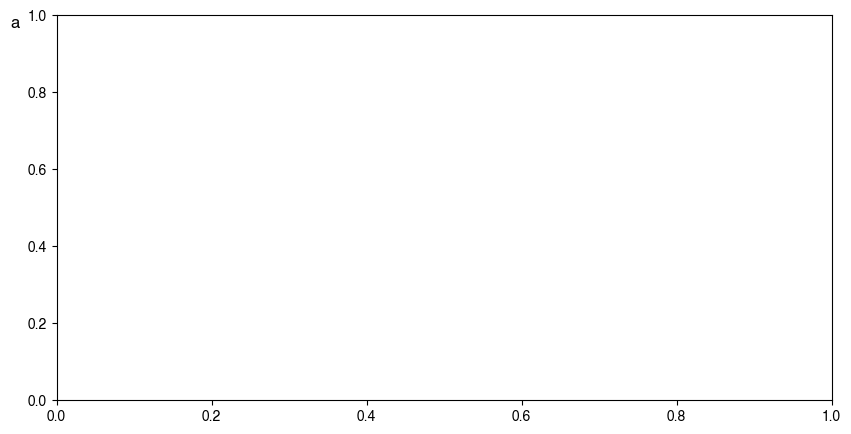

In [118]:
fig, axes = plot_comparison_combined_horizontal(
    comparison_df,
    metrics=[
        ('SMILES DOCKQ SCORE', 'CCD DOCKQ SCORE', 'AF3_DIMERS DOCKQ SCORE', 'DockQ Score')
    ],
    add_threshold=True,
    threshold_values=[0.23],
    x_labels_on_all=True,
    width=10,
    height=5,
    save=True
)

## Spearman Rank Correlations

---

In [57]:
def calculate_spearman_correlations(df):
    """
    Calculate Spearman rank correlations between specified pairs of variables.
    Returns both correlation coefficients and p-values.
    """
    # Define pairs to compare
    pairs = [
        ('SMILES DOCKQ SCORE', 'SMILES PTM', 'SMILES DockQ vs PTM'),
        ('CCD DOCKQ SCORE', 'CCD PTM', 'CCD DockQ vs PTM'),
        ('SMILES DOCKQ SCORE', 'SMILES IPTM', 'SMILES DockQ vs iPTM'),
        ('CCD DOCKQ SCORE', 'CCD IPTM', 'CCD DockQ vs iPTM'),
        ('SMILES DOCKQ SCORE', 'SMILES RMSD', 'SMILES DockQ vs RMSD'),
        ('CCD DOCKQ SCORE', 'CCD RMSD', 'CCD DockQ vs RMSD')
    ]
    
    results = []
    
    for var1, var2, label in pairs:
        # Remove rows with NaN values for this pair
        pair_df = df[[var1, var2]].dropna()
        
        # Calculate Spearman correlation
        correlation, p_value = stats.spearmanr(pair_df[var1], pair_df[var2])
        
        # Store results
        results.append({
            'Comparison': label,
            'Correlation': correlation,
            'P-value': p_value,
            'Sample Size': len(pair_df)
        })
    
    # Create results dataframe
    results_df = pd.DataFrame(results)
    
    # Format the results
    results_df['Correlation'] = results_df['Correlation'].round(3)
    results_df['P-value'] = results_df['P-value'].round(4)
    
    return results_df

In [58]:
correlation_results = calculate_spearman_correlations(df_af3)

# Display results in a nicely formatted table
print("\nSpearman Rank Correlations:")
print("============================")
print(correlation_results.to_string(index=False))


Spearman Rank Correlations:
          Comparison  Correlation  P-value  Sample Size
 SMILES DockQ vs PTM        0.584   0.0001           40
    CCD DockQ vs PTM        0.591   0.0001           40
SMILES DockQ vs iPTM        0.641   0.0000           40
   CCD DockQ vs iPTM        0.685   0.0000           40
SMILES DockQ vs RMSD       -0.719   0.0000           40
   CCD DockQ vs RMSD       -0.752   0.0000           40


In [59]:
def plot_correlation_pairs(df: pd.DataFrame, save: bool = False, title: str = None) -> None:
    COLORS = {'CCD': main_color, 'SMILES': secondary_color}
    comparisons = [
        {'title': 'DockQ Score vs pTM',
         'dockq_columns': ('CCD DOCKQ SCORE', 'SMILES DOCKQ SCORE'),
         'metric_columns': ('CCD PTM', 'SMILES PTM')},
        {'title': 'DockQ Score vs iPTM',
         'dockq_columns': ('CCD DOCKQ SCORE', 'SMILES DOCKQ SCORE'),
         'metric_columns': ('CCD IPTM', 'SMILES IPTM')},
        {'title': 'DockQ vs RMSD',
         'dockq_columns': ('CCD DOCKQ SCORE', 'SMILES DOCKQ SCORE'),
         'metric_columns': ('CCD RMSD', 'SMILES RMSD')}
    ]
    
    fig, axes = plt.subplots(1, len(comparisons), figsize=(18, 6))
    
    for i, (ax, comp) in enumerate(zip(axes, comparisons)):
        # Add subplot label (a, b, c, etc.) in the top-left corner
        subplot_label = chr(97 + i)  # 97 is ASCII for 'a'
        ax.text(-0.06, 1, subplot_label, transform=ax.transAxes, 
                fontsize=subplot_label_size, va='top', fontweight='bold')
        
        for source, dockq_col, metric_col in zip(COLORS.keys(), comp['dockq_columns'], comp['metric_columns']):
            subset = df[[dockq_col, metric_col]].dropna()
            corr, _ = stats.spearmanr(subset[dockq_col], subset[metric_col])
            marker = '^' if source == 'CCD' else 'o'
            label_text = f'Ligand {source} (ρ = {corr:.3f})'
            ax.scatter(subset[dockq_col], subset[metric_col],
                       color=COLORS[source],
                       edgecolor='black', linewidth=0.5,
                       s=60, marker=marker,
                       label=label_text)
        
        ax.set_xlabel('DockQ Score')
        ylabel = comp['title'].split(' vs ')[-1]
        if ylabel == 'RMSD':
            ylabel += ' (Å)'
        ax.set_ylabel(ylabel)
        ax.set_xlim(0)
        ax.set_ylim(0)
        legend_loc = 'lower right' if 'pTM' in comp['title'] or 'iPTM' in comp['title'] else 'best'
        ax.legend(fontsize=10, loc=legend_loc)
    
    plt.tight_layout()
    if save:
        try:
            # Create directory if it doesn't exist
            import os
            save_path = '../data/plots'
            os.makedirs(save_path, exist_ok=True)
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = title.lower().replace(' ', '_') if title else f"plot_{timestamp}"
            filename = ''.join(c for c in filename if c.isalnum() or c in ['_', '-'])
            
            plt.savefig(f'{save_path}/{filename}', dpi=300, bbox_inches='tight')
        except Exception as e:
            print(f"Error saving figure: {e}")
            # Save to current directory as fallback
            plt.savefig(filename, dpi=300)
    else:
        plt.show()

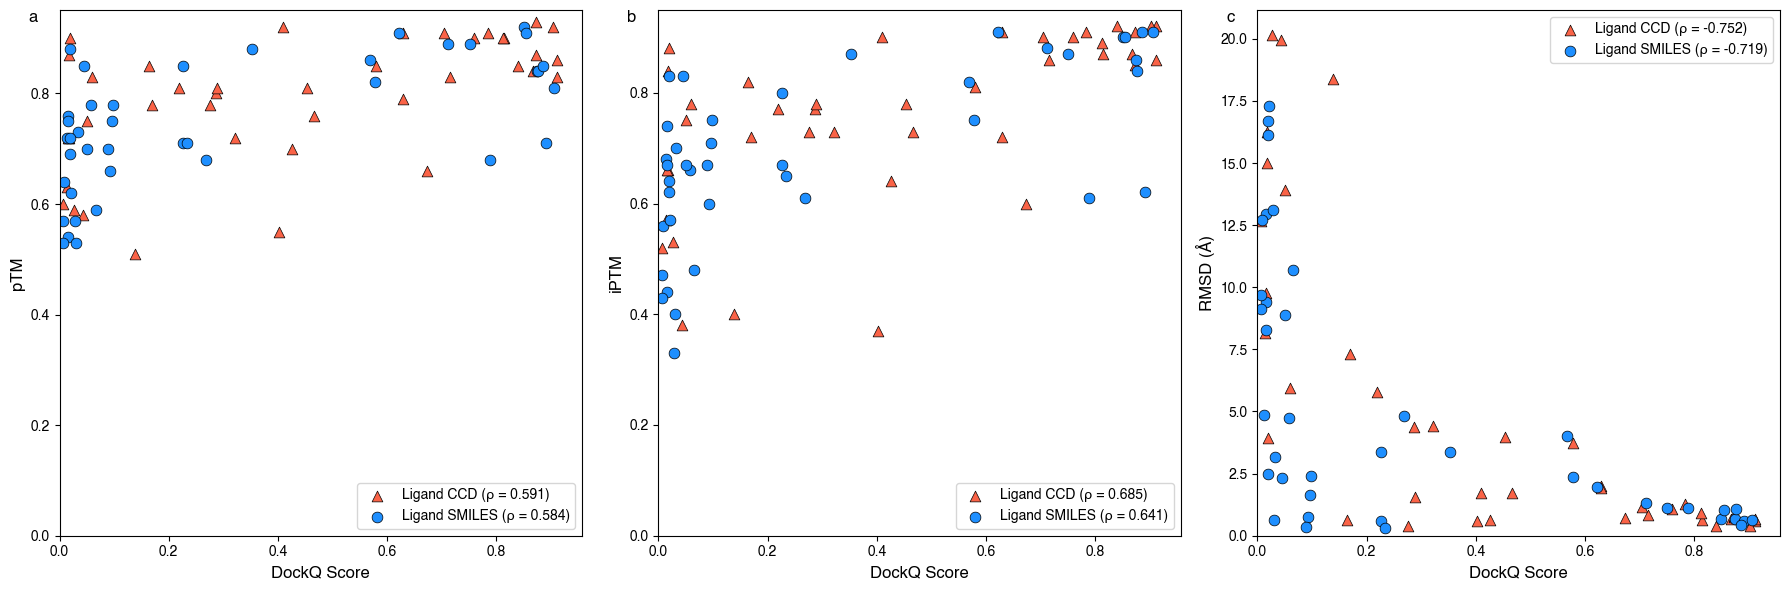

In [60]:
plot_correlation_pairs(df_af3, save=True)